In [34]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pickle as pkl 
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

ModuleNotFoundError: No module named 'torchcontrib'

In [2]:
df = pd.read_csv("7/newsCorpora.csv", sep="\t", header=None)
extracted_df = df[df[3].isin(["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"])]
shuffled_df = extracted_df.sample(frac=1, random_state=0)

In [3]:
train_df, valid_test_df = train_test_split(shuffled_df, test_size=0.2, random_state=0)
valid_df, test_df = train_test_split(valid_test_df, test_size=0.5, random_state=0)

assert len(train_df) == 10672
assert len(valid_df) == 1334
assert len(test_df)  == 1334

train_df.to_csv("7/train.txt", index=None, header=None)
valid_df.to_csv("7/valid.txt", index=None, header=None)
test_df.to_csv("7/test.txt", index=None, header=None)

In [4]:
if not Path("7/GoogleNewsModel.bin").exists():
    model = KeyedVectors.load_word2vec_format("7/GoogleNews-vectors-negative300.bin", binary=True)
    with open("7/GoogleNewsModel.bin", "wb") as f:
        pkl.dump(model, f)
else:
    model = pkl.load(open("7/GoogleNewsModel.bin", "rb"))
model

In [5]:
# Load data
columns = ["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"]
train_df = pd.read_csv("7/train.txt", header=None, names=columns)
valid_df = pd.read_csv("7/valid.txt", header=None, names=columns)
test_df = pd.read_csv("7/test.txt", header=None, names=columns)

# We only use these two columns
train_df = train_df[["TITLE", "CATEGORY"]]
valid_df = valid_df[["TITLE", "CATEGORY"]]
test_df = test_df[["TITLE", "CATEGORY"]]

# Replace category name to label index. (See readme.txt)
def category2label(x):
    return ["b", "t", "e", "m"].index(x)

train_df['CATEGORY'] = train_df['CATEGORY'].map(category2label)
valid_df['CATEGORY'] = valid_df['CATEGORY'].map(category2label)
test_df['CATEGORY'] = test_df['CATEGORY'].map(category2label)
# %%
# Save data
train_df.to_csv("7/y_train.txt", header=False, columns=["CATEGORY"], index=None)
valid_df.to_csv("7/y_valid.txt", header=False, columns=["CATEGORY"], index=None)
test_df.to_csv("7/y_test.txt", header=False, columns=["CATEGORY"], index=None)

In [6]:
def make_vectors(df, length = 1000):
  all_vectors = []
  for title in tqdm(df["TITLE"].tolist()[:length]):
    vectors = []
    words = title.lower().split()
    for word in words:
      # Note if the word is not in the model.index_to_key, skip it.
      if word not in model.index_to_key:
        continue
      vector = model[word] # Get vectors from loaded model
      vectors.append(vector)
    
    vectors = np.array(vectors)
    if len(vectors) == 0:
      mean_vector = np.zeros(300)
    else:
      mean_vector = np.mean(vectors, axis=0) # Mean value per column (See https://numpy.org/doc/stable/reference/generated/numpy.mean.html)
    
    assert mean_vector.shape == (300,)
    all_vectors.append(mean_vector)
  all_vectors = np.array(all_vectors)
  assert all_vectors.shape == (length, 300)
  return all_vectors

if not Path("7/x_train.npy").exists():
  with open('7/x_train.npy', 'wb') as f:
    np.save(f, make_vectors(train_df))

if not Path("7/x_valid.npy").exists():
  with open('7/x_valid.npy', 'wb') as f:
    np.save(f, make_vectors(valid_df))

if not Path("7/x_test.npy").exists():
  with open('7/x_test.npy', 'wb') as f:
    np.save(f, make_vectors(test_df))

In [7]:
# Create randomized weights (dim, the number of labels) https://pytorch.org/docs/stable/generated/torch.rand.html#torch-rand
W = torch.rand(300, 1000)
with open("7/x_train.npy", "rb") as f:
  x_train = np.load(f)
  x_train = torch.tensor(x_train, dtype=torch.float32)

# Note: the shape x_train and W are required same dimension
assert x_train.dtype == W.dtype == torch.float32
print(x_train.shape)

softmax = nn.Softmax(dim=1)

# Calculate Matrix product of x_train[:1] and W → Calculate its softmax
print(softmax(x_train[:1] @ W).shape)

# Calculate Matrix product of x_train[:4] and W → Calculate its softmax
print(softmax(x_train[:4] @ W).shape)

torch.Size([1000, 300])
torch.Size([1, 1000])
torch.Size([4, 1000])


In [8]:
net = nn.Linear(300, 4, bias=False) # Prepare a linear layer without *bias*. The shape is (dim, the number of labels) (See https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
loss = nn.CrossEntropyLoss() # Prepare CrossEntropyLoss (See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)

with open("7/x_train.npy", "rb") as f:
  x_train = np.load(f)
  x_train = torch.tensor(x_train, dtype=torch.float32) # Convert numpy to tensor
with open("7/y_train.txt") as f:
  y_train = [int(line) for line in f.readlines()] # Load data and convert str to int
  y_train = torch.tensor(y_train, dtype=torch.long) # Convert numpy to tensor. Note: the datatype of y_train is not float tensor but int.
print(x_train.shape, x_train[:4].shape)

y_pred1 = softmax(net(x_train[:1]))
# Calculate Matrix product of x_train[:1] and net (Hint: net.forward(x)) → Calculate its softmax
y_pred4 = softmax(net(x_train[:4]))
print(y_pred1.shape, y_pred4.shape)


torch.Size([1000, 300]) torch.Size([4, 300])
torch.Size([1, 4]) torch.Size([4, 4])


In [9]:
loss1 = loss(y_pred1, y_train[:1])
net.zero_grad() # Initialize the gradient
loss1.backward() # Calculate backword()
print(f"x1 CrossEntropyloss: {loss1}")
print(f"x1 Gradient: {net.weight.grad}")

loss4 = loss(y_pred4, y_train[:4])
net.zero_grad() # Initialize the gradient
loss4.backward() # Calculate backword()
print(f"x1-x4 CrossEntropyloss: {loss4}")
print(f"x1 Gradient: {net.weight.grad}")

x1 CrossEntropyloss: 1.383885383605957
x1 Gradient: tensor([[-0.0041, -0.0102, -0.0052,  ...,  0.0123,  0.0010,  0.0109],
        [ 0.0014,  0.0034,  0.0017,  ..., -0.0041, -0.0003, -0.0036],
        [ 0.0015,  0.0036,  0.0019,  ..., -0.0044, -0.0003, -0.0039],
        [ 0.0013,  0.0032,  0.0016,  ..., -0.0038, -0.0003, -0.0034]])
x1-x4 CrossEntropyloss: 1.3818466663360596
x1 Gradient: tensor([[ 2.1150e-03, -2.8488e-03, -2.8255e-03,  ...,  3.5022e-03,
         -1.6351e-03,  8.4493e-03],
        [-1.1406e-03,  2.2621e-03,  5.0346e-04,  ..., -3.1983e-03,
          2.6603e-03,  5.8869e-04],
        [-2.6019e-03, -1.1072e-03,  2.1219e-03,  ...,  2.7648e-03,
         -1.0694e-03, -5.8511e-03],
        [ 1.6275e-03,  1.6939e-03,  2.0019e-04,  ..., -3.0687e-03,
          4.4244e-05, -3.1869e-03]])


torch.Size([1000, 300]) torch.Size([1334])


  0%|          | 0/1000 [00:00<?, ?it/s]

1.814697027206421 0.040194783359766006


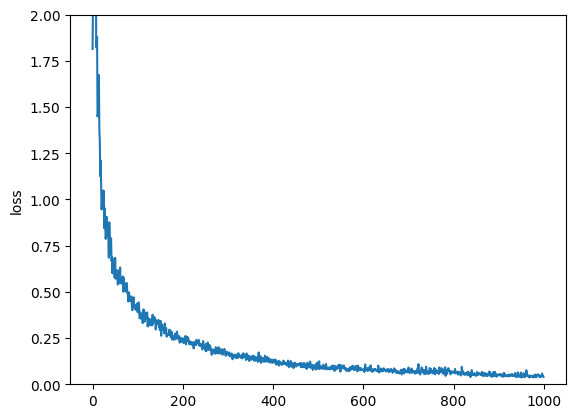

In [52]:
with open("7/x_test.npy", "rb") as f:
  # Load numpy and convert it to tensor
  x_test = np.load(f)
  x_test = torch.tensor(x_test, dtype=torch.float32)

with open("7/y_test.txt") as f:
  y_test = [int(line) for line in f.readlines()] # Load data and convert str to int
  y_test = torch.tensor(y_test, dtype=torch.long)
  # Load numpy and convert it to tensor
print(x_test.shape, y_test.shape)

x_train, y_train = x_train[:1000], y_train[:1000]
x_test, y_test = x_test[:100], y_test[:100]
x_train, y_train = x_train.to("cuda"), y_train.to("cuda")
x_test, y_test = x_test.to("cuda"), y_test.to("cuda")


class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.layers = nn.Sequential(
      nn.Dropout(0.75),
      nn.Linear(300, 4096),
      nn.ReLU(),
      nn.BatchNorm1d(4096),
      nn.Dropout(0.75),
      nn.Linear(4096, 4096),
      nn.ReLU(),
      nn.BatchNorm1d(4096),
      nn.Dropout(0.75),
      nn.Linear(4096, 4),
    )
    self.skip = nn.Sequential(
      nn.Linear(300, 4)
    )
  
  def forward(self, x):
    return self.layers(x) + self.skip(x)

# net = nn.Linear(300, 4, bias=False)
# net = nn.Sequential(
#   nn.Linear(300, 1024),
#   nn.ReLU(),
#   nn.Linear(1024, 1024),
#   nn.ReLU(),
#   nn.Linear(1024, 4)
# )

net = Model()
swa_net = optim.swa_utils.AveragedModel(net)


# Prepare a linear layer without *bias*. The shape is (dim, the number of labels) (See https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
loss_function = nn.CrossEntropyLoss() # Prepare CrossEntropyLoss (See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)
optimizer = optim.AdamW(net.parameters(), lr=0.01) # Prepare optimizer (See https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)

# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
# swa_scheduler = optim.swa_utils.SWALR(optimizer, swa_lr=0.05)
# swa_start = 500
# swa_net.to("cuda")

net.to("cuda")

net.train()

losses = []
train_acces = []
test_acces = []

for epoch in tqdm(range(1000)):
    optimizer.zero_grad()
    y_pred = net(x_train)
    # y_pred = swa_net(x_train)
    loss = loss_function(y_pred, y_train)
    loss.backward()
    optimizer.step()
    # if epoch > swa_start:
    #   swa_net.update_parameters(net)
    #   swa_scheduler.step()
    losses.append(loss.item())

    # swa_net.eval()
    # with torch.inference_mode():
    #   y_max_train, y_pred_train = torch.max(swa_net(x_train), dim=1)
    #   train_acc = accuracy_score(y_train.cpu(), y_pred_train.cpu())
    #   y_max_test, y_pred_test = torch.max(swa_net(x_test), dim=1)
    #   test_acc = accuracy_score(y_test.cpu(), y_pred_test.cpu())
    # train_acces.append(train_acc)
    # test_acces.append(test_acc)
    # swa_net.train()



# optim.swa_utils.update_bn(x_train.unsqueeze(0), swa_net, device="cuda")
# Save the weights
print(losses[0], losses[-1])

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(losses, label="loss")
ax1.set_ylim(0, 2)
ax1.set_ylabel("loss")

# ax2 = ax1.twinx()
# ax2.plot(train_acces, label="train_accuracy", color="orange")
# ax2.plot(test_acces, label="test_accuracy", color="red")
# ax2.set_ylim(0, 1)
# ax2.set_ylabel("accuracy")

plt.show()
torch.save(swa_net.state_dict(), "7/model.pt")

In [53]:
with open("7/x_test.npy", "rb") as f:
  # Load numpy and convert it to tensor
  x_test = np.load(f)
  x_test = torch.tensor(x_test, dtype=torch.float32)

with open("7/y_test.txt") as f:
  y_test = [int(line) for line in f.readlines()] # Load data and convert str to int
  y_test = torch.tensor(y_test, dtype=torch.long)
  # Load numpy and convert it to tensor
print(x_test.shape, y_test.shape)

x_test, y_test = x_test[:100], y_test[:100]
net.cpu()
x_train, y_train = x_train.cpu(), y_train.cpu()
x_test, y_test = x_test.cpu(), y_test.cpu()


y_max_train, y_pred_train = torch.max(net(x_train), dim=1) # Check the return of torch.max (See https://pytorch.org/docs/stable/generated/torch.max.html#torch-max)
print(y_train.shape, y_pred_train.shape)
# %%
print(f"Accuracy on training data: {accuracy_score(y_train, y_pred_train):.2f}")
# See https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score

y_max_test, y_pred_test = torch.max(net(x_test), dim=1)
print(f"Accuraty on test data: {accuracy_score(y_test, y_pred_test):.2f}")

torch.Size([1000, 300]) torch.Size([1334])
torch.Size([1000]) torch.Size([1000])
Accuracy on training data: 0.99
Accuraty on test data: 0.75
